## ilk adım olarak rotasyon denemeleri

* **1. deneme:** rotasyon yaparkenki mantık 0, 90, 180, 270 dereceleri deneyerek eğer içinde tesseract kullanarak keyword buluyorsa ve confidence yüksekse o açıyı kabul etmek
* **2. deneme** tesseract'ın osd (Orientation and Script Detection)  fonksiyonunu kullanmak

In [1]:
# Tesseract OCR motorunu ve Türkçe dil paketini kuralım
print("Tesseract OCR kuruluyor...")
!apt-get update > /dev/null
!apt-get install -y tesseract-ocr tesseract-ocr-tur > /dev/null
print("Tesseract kurulumu tamamlandı.")

# Gerekli Python kütüphanelerini kuralım (doctr, PyTorch backend ile birlikte)
print("Python kütüphaneleri kuruluyor...")
!pip install "python-doctr[torch]" pytesseract tqdm -q
print("Kütüphane kurulumları tamamlandı.")

# Install other required dependencies for OpenCV and Tesseract
# !pip install opencv-python-headless pytesseract numpy matplotlib

Tesseract OCR kuruluyor...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Tesseract kurulumu tamamlandı.
Python kütüphaneleri kuruluyor...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# imports
import os
import pytesseract
import numpy as np
import pandas as pd
import json
import glob
import torch
import re
from sentence_transformers import SentenceTransformer, util
from pytesseract import image_to_data, Output
from tqdm.notebook import tqdm
from skimage.filters import threshold_sauvola
from scipy.ndimage import rotate
from difflib import get_close_matches
from typing import List, Dict, Tuple, Union
import matplotlib.pyplot as plt
from google.colab import files, drive  # For file uploads and Google Drive mounting
from google.colab.patches import cv2_imshow  # For displaying images in Colab
import cv2
print("Installed dependencies.")


Installed dependencies.


## **1. deneme**
The correct_orientation_with_skew function takes an image, keywords, and language as input and corrects its orientation to prepare it for optical character recognition (OCR). It first determines the best coarse rotation (0, 90, 180, or 270 degrees) using OCR confidence and keyword counts. Next, it estimates and corrects for small, fine-grained skew angles using a technique called the Hough transform. Finally, it performs an optional micro-refinement step by rotating the image by a few nearby angles and picking the one that maximizes the variance of horizontal text projections, a proxy for straight text lines. This pipeline produces a final, precisely oriented image and the total rotation angle applied.

In [5]:
def rotate_image_precise(image, angle, background_color=(255, 255, 255)):
    """
    Why used:
      - Apply arbitrary-angle rotation WITHOUT cropping, so no text is lost.
      - Used for both coarse (0/90/180/270) and fine skew corrections before OCR.
    """
    if angle == 0: return image
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos, sin = np.abs(M[0, 0]), np.abs(M[0, 1])
    nW, nH = int((h * sin) + (w * cos)), int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]
    return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_CONSTANT, borderValue=background_color)

def estimate_skew_hough(image):
    """
    Why used:
      - After coarse rotation, receipts may still be slightly tilted.
      - Detects small skew via Hough lines and returns a robust median angle.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inverted = cv2.bitwise_not(gray)
    thresh = cv2.adaptiveThreshold(inverted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    dilated = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=1)
    edges = cv2.Canny(dilated, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 150,
                            minLineLength=100, maxLineGap=20)
    angles = []
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            if x2 == x1: continue
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if -45 < angle < 45:
                angles.append(angle)
    return np.median(angles) if angles else 0

In [6]:
def projection_variance_score(img):
    """
    Why used:
      - Cheap numeric proxy for “how straight” text lines are.
      - Enables micro-refinement by comparing nearby angles (higher = better).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(thresh)
    proj = np.sum(inverted, axis=1)
    return np.var(proj)

In [7]:
def compute_avg_conf(data):
  confs = []
  for txt, conf in zip(data['text'], data['conf']):
      try:
          val = float(conf)
          if txt.strip() and 0 < val < 100:
              confs.append(val)
      except:
          continue
  return np.mean(confs) if confs else 0

In [8]:
def count_keywords(text, keywords):
    """
    Why used:
      - Receipts contain domain-specific tokens (TOPLAM, ONAY, etc.).
      - Acts as a prior to break ties when OCR confidences are close.
    """
    text = text.upper()
    return sum(text.count(k.upper()) for k in keywords)

def find_best_orientation(image, keywords, lang='tur'):
    """
    Why used:
      - Doctr is rotation-sensitive; choose best of 0/90/180/270 FIRST.
      - Scores each angle by (keyword hits + OCR confidence), with a small angle penalty,
        then returns the top candidate to feed into skew correction.
    """
    best_img = image
    best_angle = 0
    best_score = -1
    best_conf = 0
    best_kw_count = 0

    angle_penalty = {
        0: 1.0,
        90: 0.85,
        180: 0.7,
        270: 0.85
    }

    for angle in [0, 90, 180, 270]:
        rotated = rotate_image_precise(image, angle)
        data = pytesseract.image_to_data(rotated, lang=lang, output_type=Output.DICT)
        conf = compute_avg_conf(data)
        text = " ".join(data['text'])
        kw_count = count_keywords(text, keywords)

        # Apply penalty to prefer natural upright when signals tie
        base_score = kw_count * 1000 + conf
        final_score = base_score * angle_penalty.get(angle, 0.7)

        if final_score > best_score:
            best_score = final_score
            best_img = rotated
            best_angle = angle
            best_conf = conf
            best_kw_count = kw_count

    return best_img, best_angle


In [9]:
def correct_orientation_with_skew(image, keywords=None, lang='tur+eng',
                                  skew_range=5, step=1.0, top_n_angles=3):
    """
    Why used:
      - Single entry point to produce a Doctr-ready image.
      - Pipeline: coarse rotation → small skew estimation → optional micro-refine.
      - Returns final image + total angle for audit/reproducibility.
    """
    # Step 1: Try 0°, 90°, 180°, 270°
    upright_img, base_angle = find_best_orientation(image, keywords, lang=lang)

    # Step 2: Estimate fine skew angle
    skew_angle = estimate_skew_hough(upright_img)
    corrected_img = rotate_image_precise(upright_img, skew_angle)

    # Step 3: Optionally refine skew using projection variance
    # print("Refining skew...")
    angles = np.arange(skew_angle - skew_range, skew_angle + skew_range + step, step)
    scored_angles = []
    for a in angles:
        r = rotate_image_precise(upright_img, a)
        score = projection_variance_score(r)
        scored_angles.append((a, score))

    top_angles = sorted(scored_angles, key=lambda x: -x[1])[:top_n_angles]
    best_conf = compute_avg_conf(pytesseract.image_to_data(corrected_img, lang=lang, output_type=Output.DICT))
    best_img = corrected_img
    best_angle = base_angle + skew_angle

    for a, _ in top_angles:
        rotated = rotate_image_precise(upright_img, a)
        data = pytesseract.image_to_data(rotated, lang=lang, output_type=Output.DICT)
        conf = compute_avg_conf(data)
        if conf > best_conf:
            best_conf = conf
            best_img = rotated
            best_angle = base_angle + a

    return best_img, best_angle

In [10]:
keywords_for_detection = [
    'TOPLAM', 'TUTAR', 'KDV', 'TL', 'FATURA', 'TARİH', 'SAAT', 'İŞLEM', 'MÜŞTERİ', 'BAŞARILI',
    'SATIŞ', 'TUTARI', 'YERMİNAL', 'GARANTİ', 'ONAY', 'MERSIS', 'KART', 'BANKA', 'NO', 'ADET',
    'ISLEM', 'PARAMETRE', 'YUKLEME', 'TERMİNAL', 'ISYERİ', 'TERMINAL', 'BATCH', 'GARANTI BBVA',
    'DENIZBANK', 'TOPKDV', '1,00 TL', 'SATIŞ TUTARI', 'İŞLEM TUTARI','IPTAL','İPTAL','ISYERI',
]

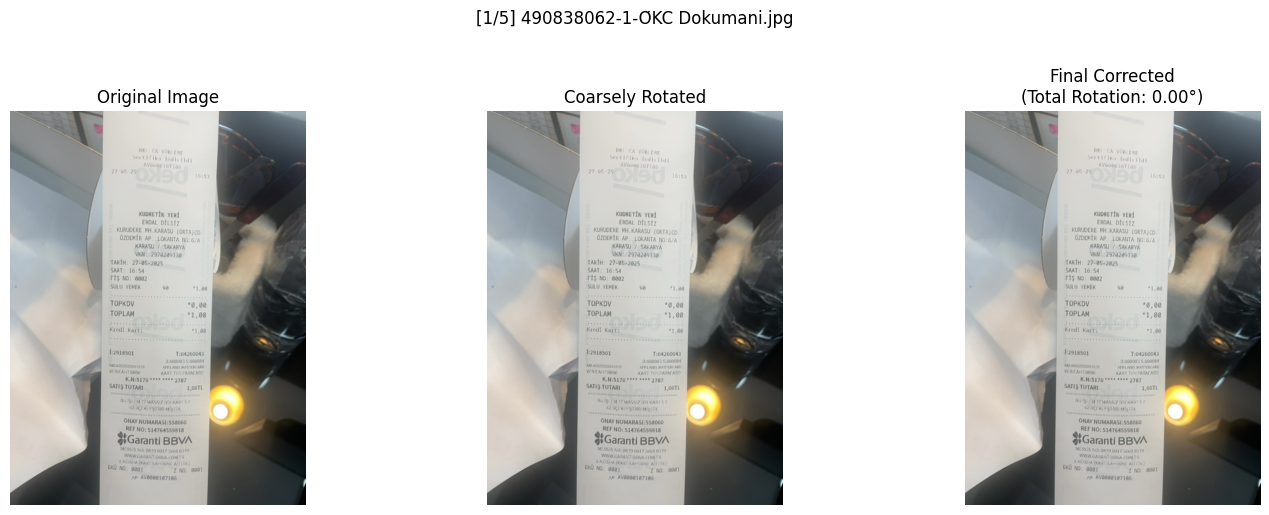

[1/5] Saved: /content/rotation_corrected/490838062-1-ÖKC Dokumani_corrected.png | angle=0.00°


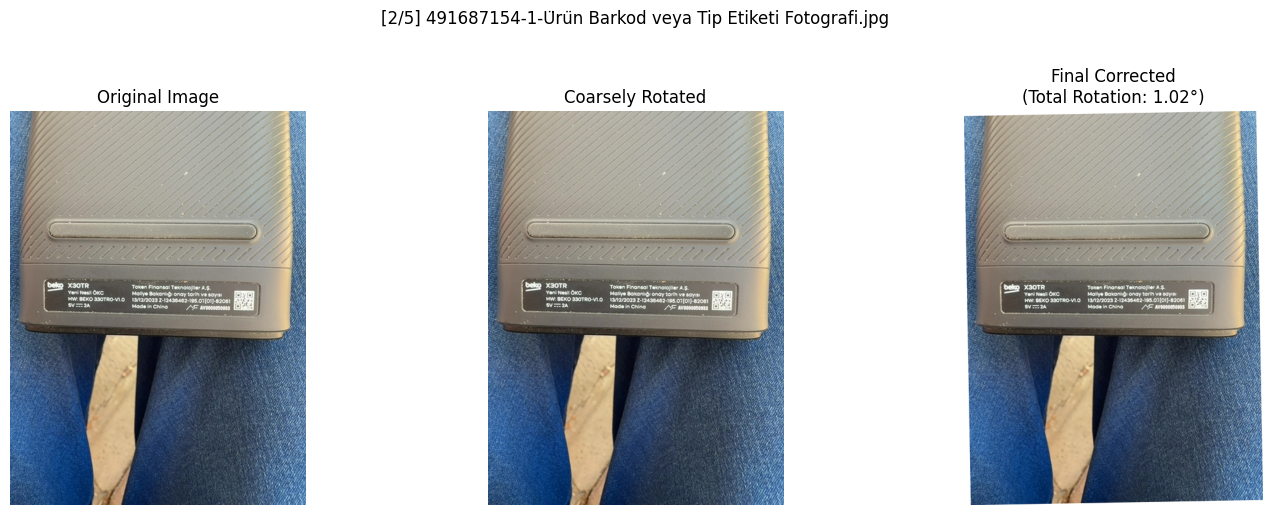

[2/5] Saved: /content/rotation_corrected/491687154-1-Ürün Barkod veya Tip Etiketi Fotografi_corrected.png | angle=1.02°


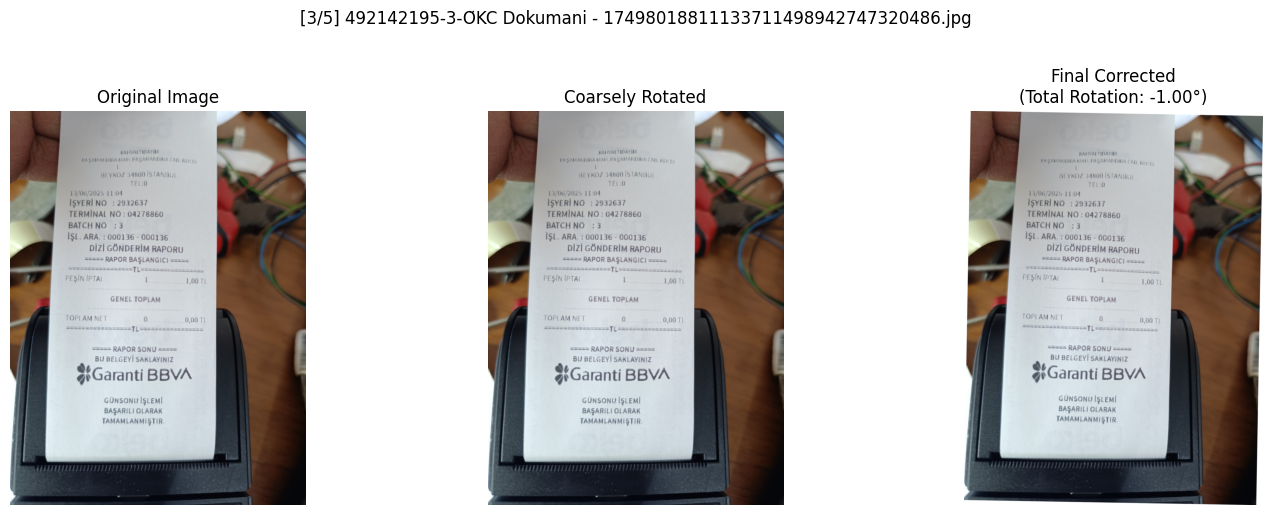

[3/5] Saved: /content/rotation_corrected/492142195-3-ÖKC Dokumani - 17498018811133711498942747320486_corrected.png | angle=-1.00°


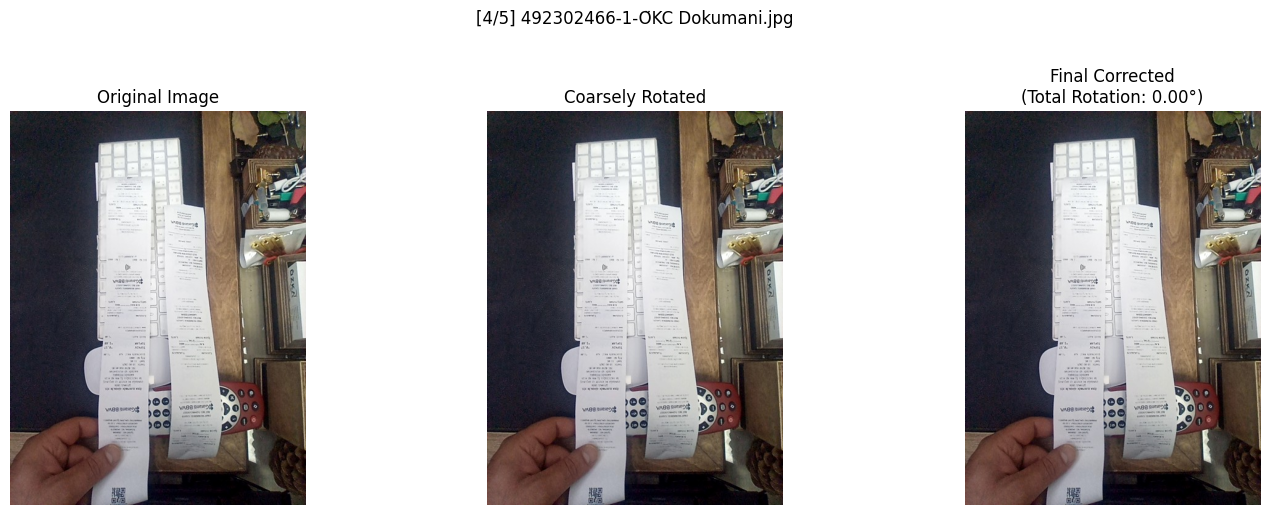

[4/5] Saved: /content/rotation_corrected/492302466-1-ÖKC Dokumani_corrected.png | angle=0.00°


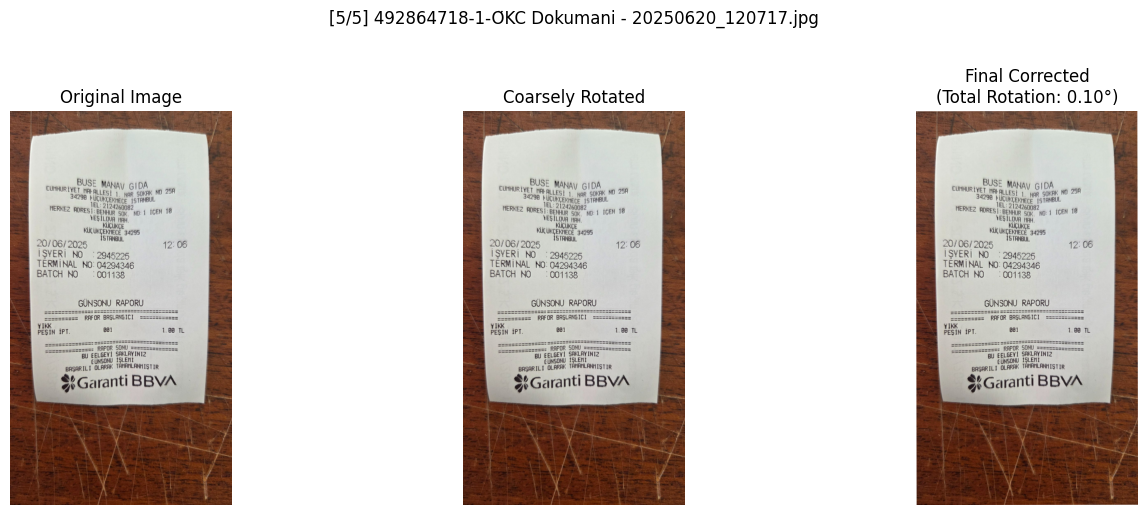

[5/5] Saved: /content/rotation_corrected/492864718-1-ÖKC Dokumani - 20250620_120717_corrected.png | angle=0.10°

Done. Corrected images → /content/rotation_corrected
Angles CSV → /content/rotation_corrected/rotation_angles.csv


In [11]:
import os, glob, csv
import cv2
import matplotlib.pyplot as plt

# === Configure these ===
INPUT_DIR  = '/content/drive/MyDrive/deneme2'      # <-- change to your folder
OUTPUT_DIR = '/content/rotation_corrected'
ALLOWED_EXTS = ('*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff', '*.bmp')
MAX_IMAGES = 5

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Collect up to 5 images
image_paths = []
for ext in ALLOWED_EXTS:
    image_paths.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
image_paths = sorted(image_paths)[:MAX_IMAGES]

if not image_paths:
    raise SystemExit(f"No images found in {INPUT_DIR} (looked for {ALLOWED_EXTS}).")

# CSV to log angles
angles_csv = os.path.join(OUTPUT_DIR, 'rotation_angles.csv')
with open(angles_csv, 'w', newline='', encoding='utf-8') as fcsv:
    writer = csv.writer(fcsv)
    writer.writerow(['filename', 'total_angle_degrees'])

    for idx, image_path in enumerate(image_paths, 1):
        try:
            img_cv2 = cv2.imread(image_path)
            if img_cv2 is None:
                print(f"[warn] Could not read: {image_path}")
                continue

            # Final correction
            corrected_img, total_angle = correct_orientation_with_skew(
                img_cv2, keywords=keywords_for_detection
            )

            # Coarse orientation preview
            upright_img, _ = find_best_orientation(
                img_cv2, keywords=keywords_for_detection
            )

            # Save corrected image
            base = os.path.splitext(os.path.basename(image_path))[0]
            out_path = os.path.join(OUTPUT_DIR, f"{base}_corrected.png")
            cv2.imwrite(out_path, corrected_img)

            # Log angle
            writer.writerow([os.path.basename(image_path), f"{total_angle:.4f}"])

            # ---- Display triptych for this image ----
            plt.figure(figsize=(15, 5))

            # Original
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')

            # Coarsely Rotated
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(upright_img, cv2.COLOR_BGR2RGB))
            plt.title('Coarsely Rotated')
            plt.axis('off')

            # Final Corrected
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Final Corrected\n(Total Rotation: {total_angle:.2f}°)')
            plt.axis('off')

            plt.suptitle(f"[{idx}/{len(image_paths)}] {os.path.basename(image_path)}", y=1.02)
            plt.tight_layout()
            plt.show()

            print(f"[{idx}/{len(image_paths)}] Saved: {out_path} | angle={total_angle:.2f}°")

        except Exception as e:
            print(f"[error] {image_path}: {e}")

print(f"\nDone. Corrected images → {OUTPUT_DIR}")
print(f"Angles CSV → {angles_csv}")


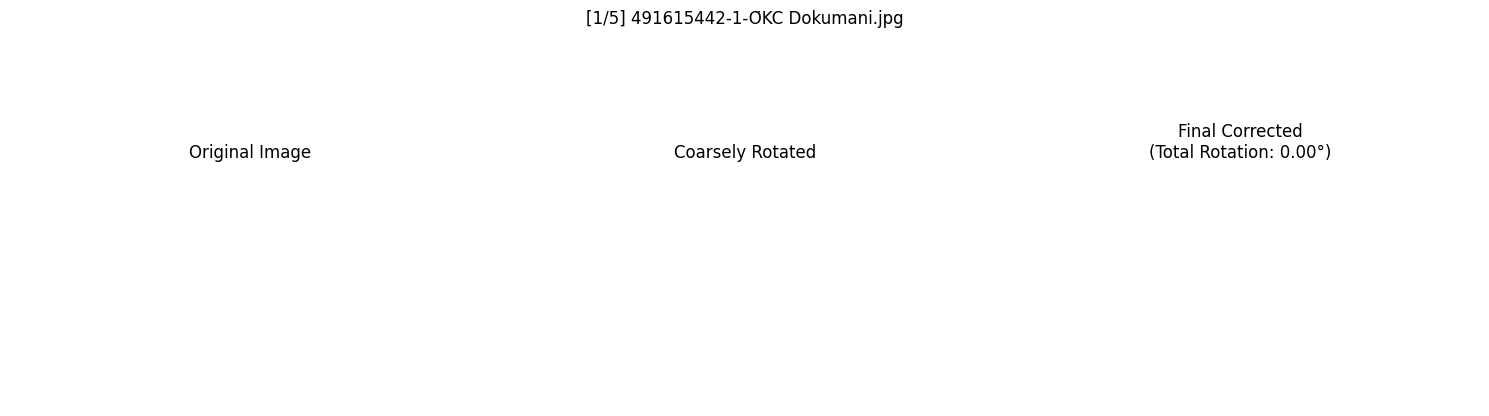

[1/5] Saved: /content/rotation_corrected/491615442-1-ÖKC Dokumani_corrected.png | angle=0.00°


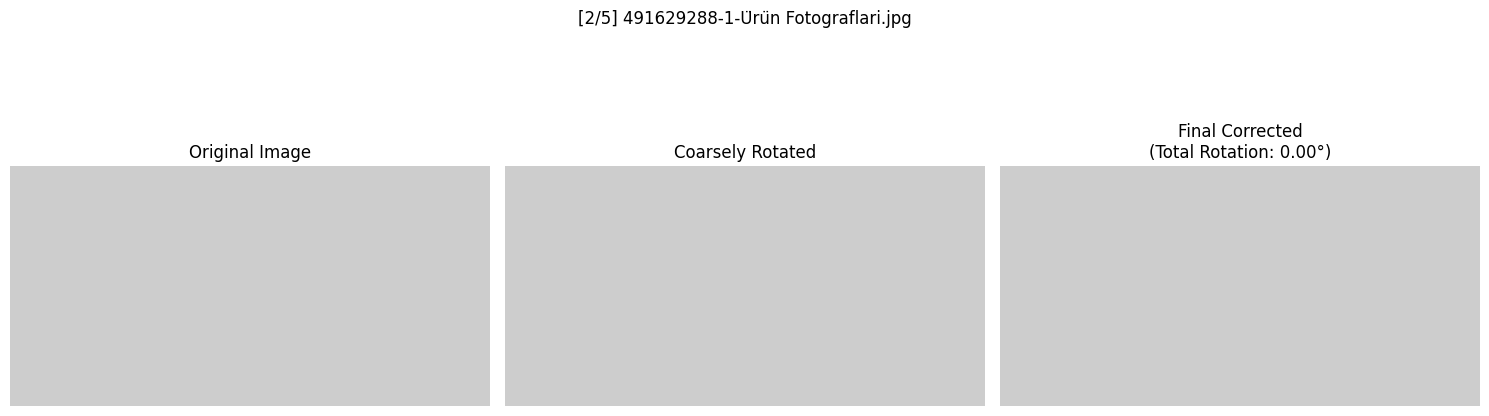

[2/5] Saved: /content/rotation_corrected/491629288-1-Ürün Fotograflari_corrected.png | angle=0.00°


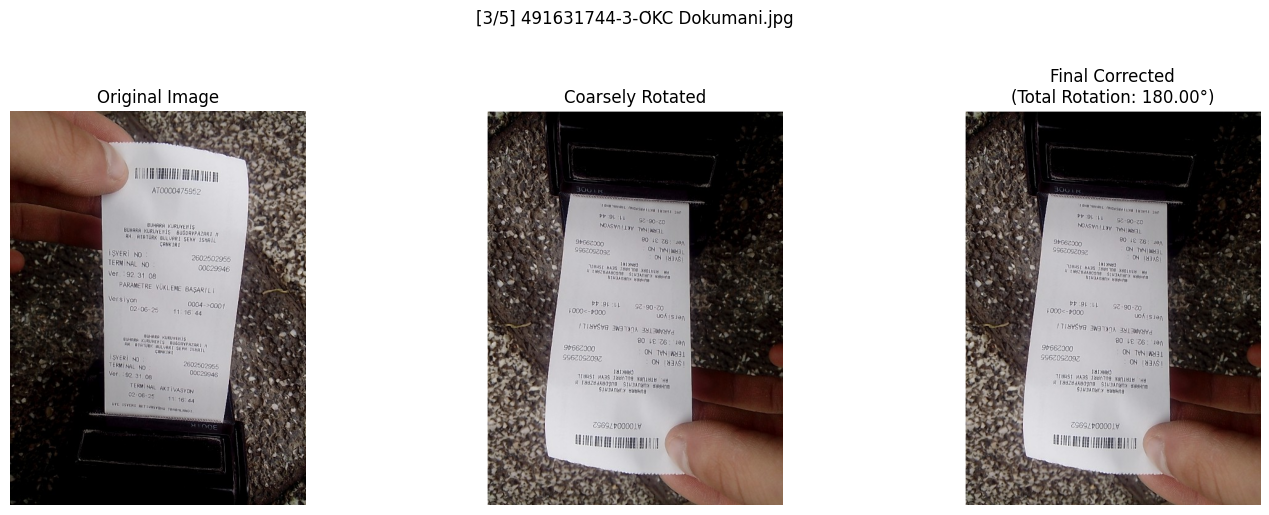

[3/5] Saved: /content/rotation_corrected/491631744-3-ÖKC Dokumani_corrected.png | angle=180.00°


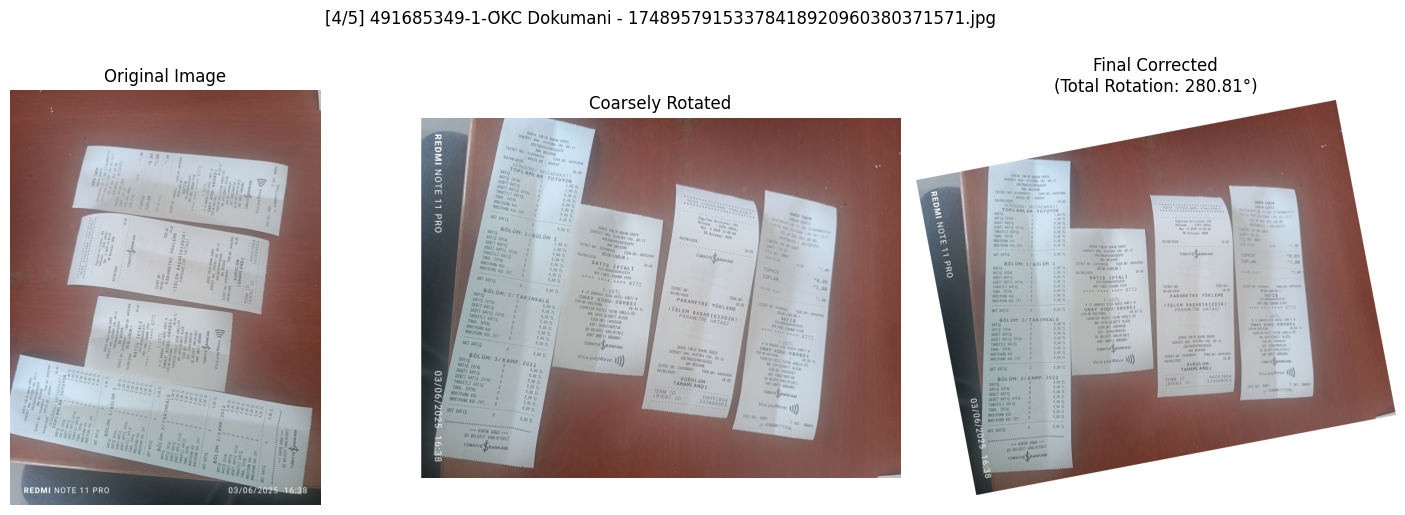

[4/5] Saved: /content/rotation_corrected/491685349-1-ÖKC Dokumani - 17489579153378418920960380371571_corrected.png | angle=280.81°


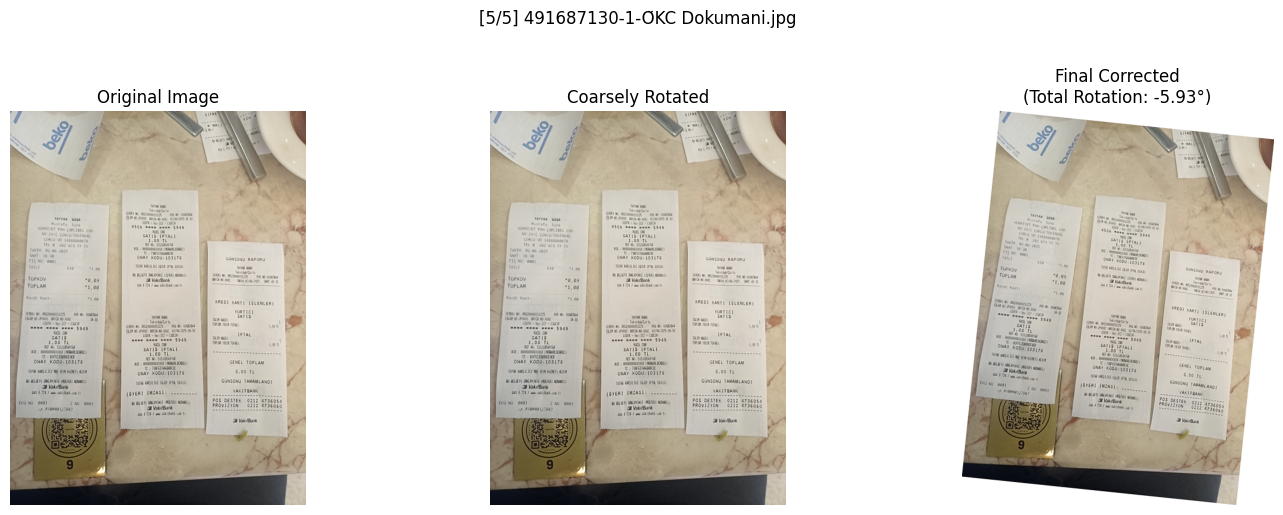

[5/5] Saved: /content/rotation_corrected/491687130-1-ÖKC Dokumani_corrected.png | angle=-5.93°

Done. Corrected images → /content/rotation_corrected
Angles CSV → /content/rotation_corrected/rotation_angles.csv


In [12]:
import os, glob, csv
import cv2
import matplotlib.pyplot as plt

# === Configure these ===
INPUT_DIR  = '/content/drive/MyDrive/deneme1'      # <-- change to your folder
OUTPUT_DIR = '/content/rotation_corrected'
ALLOWED_EXTS = ('*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff', '*.bmp')
MAX_IMAGES = 5

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Collect up to 5 images
image_paths = []
for ext in ALLOWED_EXTS:
    image_paths.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
image_paths = sorted(image_paths)[:MAX_IMAGES]

if not image_paths:
    raise SystemExit(f"No images found in {INPUT_DIR} (looked for {ALLOWED_EXTS}).")

# CSV to log angles
angles_csv = os.path.join(OUTPUT_DIR, 'rotation_angles.csv')
with open(angles_csv, 'w', newline='', encoding='utf-8') as fcsv:
    writer = csv.writer(fcsv)
    writer.writerow(['filename', 'total_angle_degrees'])

    for idx, image_path in enumerate(image_paths, 1):
        try:
            img_cv2 = cv2.imread(image_path)
            if img_cv2 is None:
                print(f"[warn] Could not read: {image_path}")
                continue

            # Final correction
            corrected_img, total_angle = correct_orientation_with_skew(
                img_cv2, keywords=keywords_for_detection
            )

            # Coarse orientation preview
            upright_img, _ = find_best_orientation(
                img_cv2, keywords=keywords_for_detection
            )

            # Save corrected image
            base = os.path.splitext(os.path.basename(image_path))[0]
            out_path = os.path.join(OUTPUT_DIR, f"{base}_corrected.png")
            cv2.imwrite(out_path, corrected_img)

            # Log angle
            writer.writerow([os.path.basename(image_path), f"{total_angle:.4f}"])

            # ---- Display triptych for this image ----
            plt.figure(figsize=(15, 5))

            # Original
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')

            # Coarsely Rotated
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(upright_img, cv2.COLOR_BGR2RGB))
            plt.title('Coarsely Rotated')
            plt.axis('off')

            # Final Corrected
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Final Corrected\n(Total Rotation: {total_angle:.2f}°)')
            plt.axis('off')

            plt.suptitle(f"[{idx}/{len(image_paths)}] {os.path.basename(image_path)}", y=1.02)
            plt.tight_layout()
            plt.show()

            print(f"[{idx}/{len(image_paths)}] Saved: {out_path} | angle={total_angle:.2f}°")

        except Exception as e:
            print(f"[error] {image_path}: {e}")

print(f"\nDone. Corrected images → {OUTPUT_DIR}")
print(f"Angles CSV → {angles_csv}")



---


## **2. Tesseract'ın OSD fonksiyonu ile deneme**

In [13]:
def preprocess_for_osd(img_bgr, upscale=True):
    """
    Prepares an image for Tesseract OSD: grayscale, denoise, optional CLAHE, optional upscale.
    Returns a single-channel uint8 image ready for OSD.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.fastNlMeansDenoising(gray, h=10)

    # CLAHE (better than global equalization for receipts)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    if upscale:
        gray = cv2.resize(gray, None, fx=1.8, fy=1.8, interpolation=cv2.INTER_CUBIC)

    # Light binarization for OSD (small blockSize so lines remain solid)
    bin_img = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
        21, 7
    )

    # Detect if inversion needed — sample 5% border area
    h, w = bin_img.shape
    border = int(min(h, w) * 0.05)
    corner = bin_img[:border, :border]
    if np.mean(corner) < 128:  # dark border → invert
        bin_img = cv2.bitwise_not(bin_img)

    return bin_img

In [14]:
def preprocess_for_osd(img_bgr, upscale=True):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.fastNlMeansDenoising(gray, h=10)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    if upscale:
        gray = cv2.resize(gray, None, fx=1.8, fy=1.8, interpolation=cv2.INTER_CUBIC)
    bin_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 21, 7)
    h, w = bin_img.shape
    border = int(min(h, w) * 0.05)
    if np.mean(bin_img[:border, :border]) < 128:
        bin_img = cv2.bitwise_not(bin_img)
    return bin_img  # single-channel uint8

def run_osd(img_bgr):
    prepped = preprocess_for_osd(img_bgr)           # 1-channel
    # You can pass grayscale directly, or convert properly:
    osd_data = pytesseract.image_to_osd(prepped, output_type=Output.DICT, config="--psm 0")
    angle = int(osd_data.get("rotate", 0))
    return angle, None

def rotate_image_precise(image, angle, background_color=(255,255,255)):
    if angle == 0: return image
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    cos, sin = abs(M[0,0]), abs(M[0,1])
    nW, nH = int((h*sin)+(w*cos)), int((h*cos)+(w*sin))
    M[0,2] += (nW/2) - (w//2)
    M[1,2] += (nH/2) - (h//2)
    return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_CONSTANT, borderValue=background_color)

def apply_osd_correction(img_bgr):
    angle, err = run_osd(img_bgr)   # now defined
    if err:
        print(f"[warn] {err} — keeping as-is")
        return img_bgr, 0
    return rotate_image_precise(img_bgr, -angle), angle


# **OSD ile ornek deneme**

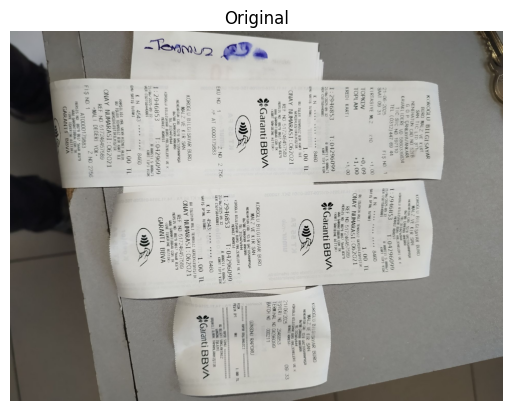

OSD detected angle: 270° — corrected image shown below:


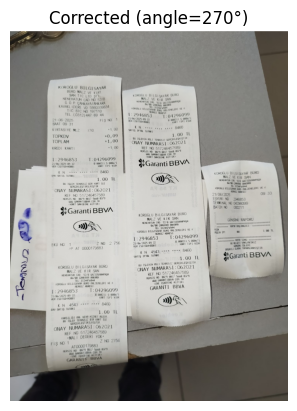

In [15]:
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt

# 1. Read your receipt image
image_path = "/content/drive/MyDrive/deneme/Copy of 492964552-1-ÖKC Dokumani - IMG_20250621_093316.jpg"
img_bgr = cv2.imread(image_path)

# 2. Show original image
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")
plt.show()

# 3. Run OSD rotation detection & correction
corrected, angle = apply_osd_correction(img_bgr)

print(f"OSD detected angle: {angle}° — corrected image shown below:")

# 4. Show corrected image
plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
plt.title(f"Corrected (angle={angle}°)")
plt.axis("off")
plt.show()

# her acinin denendigi ile ayni resmin denemesi

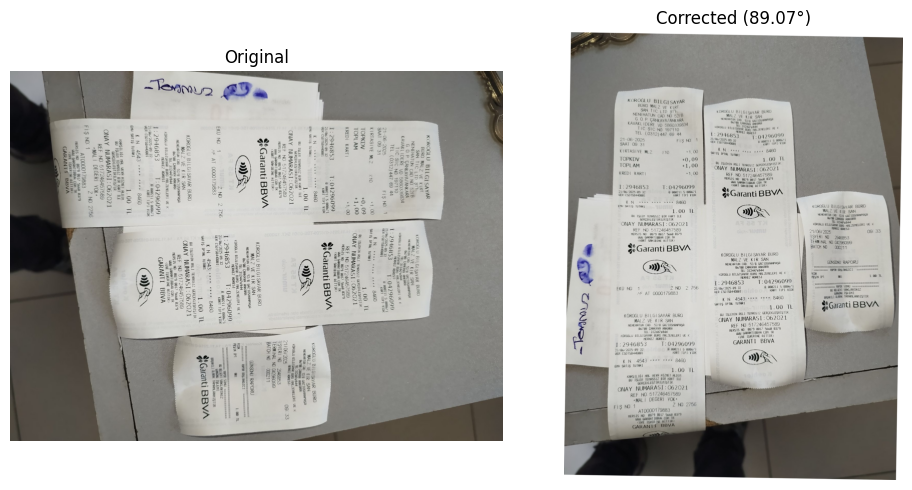

Saved corrected image → /content/rotation_corrected/image_corrected.png
Total rotation applied (coarse+skew): 89.07°


In [16]:
# ====== Single-image run ======
image_path = "/content/drive/MyDrive/deneme/Copy of 492964552-1-ÖKC Dokumani - IMG_20250621_093316.jpg"
output_path = "/content/rotation_corrected/image_corrected.png"

img_cv2 = cv2.imread(image_path)
if img_cv2 is None:
    raise SystemExit(f"Could not read: {image_path}")

corrected_img, total_angle = correct_orientation_with_skew(
    img_cv2, keywords=keywords_for_detection
)

os.makedirs(os.path.dirname(output_path), exist_ok=True)
cv2.imwrite(output_path, corrected_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB)); plt.title(f"Corrected ({total_angle:.2f}°)"); plt.axis("off")
plt.tight_layout(); plt.show()

print(f"Saved corrected image → {output_path}")
print(f"Total rotation applied (coarse+skew): {total_angle:.2f}°")


### kendi düşüncem
tesseract osd çok sorun çıkarıyor ilk yöntemle devam etmek mantıklı olabilir